In [ ]:
library(jsonlite)
library(dplyr)
library(ridigbio)

We will explore U.S. natural history collection sizes based on their published data aggregated by iDigBio. Collections data will be from accessed from the iDigBio Collections catalog and specimen data will be queried via the iDigBio specimen record API:

https://github.com/iDigBio/idb-us-collections

https://github.com/idigbio/idigbio-search-api/wiki


First, let's create a dataframe of U.S. collections and subset it to collections that have specimen data aggregated by iDigBio:

In [5]:
# Get data from the collections catalog
df <- fromJSON("http://idigbio.github.io/idb-us-collections/collections.json")
# Let's only look at collections with data
df <- df %>% filter(recordsetQuery!="")
head(df, n=2)

institution,collection,recordsets,recordsetQuery,institution_code,collection_code,collection_uuid,collection_lsid,collection_url,collection_catalog_url,...,physical_zip,UniqueNameUUID,attributionLogoURL,providerManagedID,derivedFrom,sameAs,flags,portalDisplay,lat,lon
University of South Carolina Salkehatchie,Herbarium,50ca2a08-0e76-4f56-9976-d344dd201a9b,"{""recordset"":""50ca2a08-0e76-4f56-9976-d344dd201a9b""}",SALK<IH>,,urn:uuid:001c5234-048b-11e5-b0ee-002315492bbc,,http://herbarium.biol.sc.edu/floracaroliniana/collections/index.php,,...,29488,urn:uuid:2657bc25-1383-467a-a68a-263854514a5f,,,,http://sweetgum.nybg.org/science/ih/herbarium_details.php?irn=243623,,,33.0802,-81.1871
University of Delaware,Insects,"2c662e9e-cdc6-4bbf-93a5-1566ceca1af3, 5975bbda-cd92-4084-8a09-ce1e28e6164f","[{""recordset"":""2c662e9e-cdc6-4bbf-93a5-1566ceca1af3""},{""recordset"":""5975bbda-cd92-4084-8a09-ce1e28e6164f"",""institutioncode"":""udcc""}]",UD,UDCC,urn:uuid:002a70a8-ff18-11e4-9eb2-002315492bbc,http://grbio.org/cool/jwkg-m8hx,,,...,19716,urn:uuid:85917719-7ef7-4a56-961b-73f33a30d78a,,,,,,,39.6697,-75.7529


In [11]:
##Augment this data with counts and type information
for (i in seq_along(df$collection_uuid)){
  if(nrow(as.data.frame(fromJSON(df$recordsetQuery[i])))>1 &length(fromJSON(df$recordsetQuery[i],simplifyVector = list()))>1 & !class(fromJSON(df$recordsetQuery[i]))=="list"){
    countVector <- c()
    typeVector <- c()  
    for(ii in 1:length(fromJSON(df$recordsetQuery[i],simplifyVector = list()))){
      rqCount <- idig_count_records(rq=fromJSON(df$recordsetQuery[i],simplifyVector = list())[[ii]])
      countVector <- c(countVector,rqCount)
      rqType <- names(idig_top_records(rq=fromJSON(df$recordsetQuery[i],simplifyVector = list())[[ii]],top_fields ="kingdom" )[[1]])[1]
      if(rqType=="plantae"){typeVector <-c(typeVector,rqType)}else{
                rqType <- names(idig_top_records(rq=fromJSON(df$recordsetQuery[i],simplifyVector = list())[[ii]],top_fields ="phylum" )[[1]])[1]
                typeVector <-c(typeVector,rqType)
      }
    
    }
    df$count[i] <- sum(countVector)
    df$type[i] <- paste0(unique(typeVector),collapse = ", ")
  }else{
    df$count[i] <- idig_count_records(rq=fromJSON(df$recordsetQuery[i]))
    rqT <- names(idig_top_records(rq=fromJSON(df$recordsetQuery[i]),top_fields ="kingdom" )[[1]])[1]
    if(!is.na(rqT)&rqT=="plantae"){df$type[i] <- names(idig_top_records(rq=fromJSON(df$recordsetQuery[i]),top_fields ="kingdom" )[[1]])[1]}else{
        df$type[i] <- names(idig_top_records(rq=fromJSON(df$recordsetQuery[i]),top_fields ="phylum" )[[1]])[1]
    }
  }
    
}

In [12]:
unique(df$type)

[1] "plantae"             "arthropoda"          "chordata"           
 [4] "basidiomycota"       "ascomycota"          "tracheophyta"       
 [7] "mollusca"            NA                    "tardigrada"         
[10] "eumolpianus eumolpi" "euchlanis dilatata"  "brachiopoda"        
[13] "bryozoa"             "foraminifera"

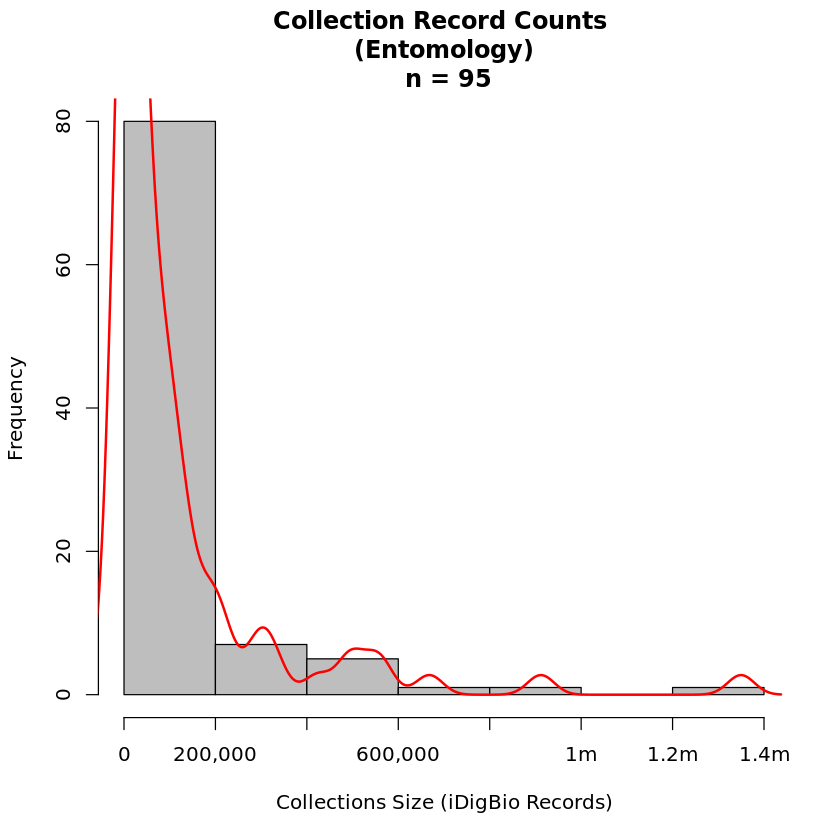

In [14]:
## Subset to arthropod collections
ento <- df %>% filter(grepl("arthropoda",type,ignore.case = T)) %>% arrange(desc(count))

# Make histogram
options(scipen=999)
histBreaks <- hist(ento$count, main = paste0("Collection Record Counts \n (Entomology) \n n = ",nrow(ento)),xlab = "Collections Size (iDigBio Records)",col = "grey",xaxt="no")
axis(1, at=seq(0,1400000,by=200000),labels = c("0","200,000","400,000","600,000","800,000","1m","1.2m","1.4m")) 
d <- density(ento$count)
lines(x = d$x, y = d$y * length(ento$count) * diff(hist(ento$count,plot = F)$breaks)[1], lwd = 2,col="red")

Let's look at entomolgy collections in detail

In [31]:
nrow(ento)
quantile(ento$count)
any(duplicated(ento$institution))

[1] 95

0%       25%       50%       75%      100% 
     37.0    6564.5   31532.0  114361.0 1349824.0

[1] TRUE

In [32]:
filE <- count(ento,institution) %>% filter(n>=2) %>% select(institution)
ento[ento$institution %in% filE$institution,]  %>% arrange(desc(institution)) %>% head()

institution,collection,recordsets,recordsetQuery,institution_code,collection_code,collection_uuid,collection_lsid,collection_url,collection_catalog_url,...,attributionLogoURL,providerManagedID,derivedFrom,sameAs,flags,portalDisplay,lat,lon,count,type
"University of Illinois, Illinois Natural History Survey",Insects,"dde625e8-cc2a-4877-9ec4-0b8a20dfded9, 57b1a2a3-78ab-4e69-a77e-a8fd4394ee5a","{""recordset"":[""dde625e8-cc2a-4877-9ec4-0b8a20dfded9"",""57b1a2a3-78ab-4e69-a77e-a8fd4394ee5a""]}",INHS,Insect Collection,urn:uuid:adc89d3d-9aae-4175-904e-78b79571be54,http://grbio.org/cool/6fqq-t4za,http://wwx.inhs.illinois.edu/collections/insect,http://inhsinsectcollection.speciesfile.org/InsectCollection.aspx,...,,,,,,,40.1320,-88.2332,667956,arthropoda
"University of Illinois, Illinois Natural History Survey",Crustacea,ec135c9b-ff89-4f28-aa18-88b16d932d94,"{""recordset"":""ec135c9b-ff89-4f28-aa18-88b16d932d94""}",INHS,,urn:uuid:39d11e8f-0fd7-43c5-9f3d-574f3e63b0d1,,http://wwx.inhs.illinois.edu/collections/crustaceans,,...,,,,,,,40.1320,-88.2332,16175,arthropoda
University of Colorado Museum of Natural History,Entomology,82541f90-fe8e-4d66-84d8-4fe515dc5533,"{""recordset"":""82541f90-fe8e-4d66-84d8-4fe515dc5533""}",UCM,Ent,urn:uuid:fa398d57-9320-41e9-89a3-6784355a2da4,http://grbio.org/cool/1s58-wraz,https://cumuseum.colorado.edu/research/entomology,https://cumuseum.colorado.edu/research/entomology/databases,...,,,,,,,40.0373,-105.2821,100748,arthropoda
University of Colorado Museum of Natural History,Paleontology - Invertebrates and Plants,d621e959-2633-4ec1-a2a2-5d97cd818b47,"{""recordset"":""d621e959-2633-4ec1-a2a2-5d97cd818b47""}",UCM,IP,urn:uuid:457f02e6-0608-4731-a834-d8c45b7fa36d,,https://cumuseum.colorado.edu/research/paleontology/invertebrates,https://cumuseum.colorado.edu/research/paleontology/invertebrates/database,...,,,,,,,40.0373,-105.2821,76804,arthropoda
"Ohio State University, Museum of Biological Diversity",Acarology,95773ebb-2f5f-43f0-a652-bfd8d5f4707a,"{""recordset"":""95773ebb-2f5f-43f0-a652-bfd8d5f4707a""}",OSAL,,urn:uuid:0e3325c8-260a-4551-9316-b51f19e604bc,urn:lsid:biocol.org:col:34094,http://www.biosci.ohio-state.edu/~acarolog/collection/index.html,http://osuc.biosci.ohio-state.edu/Acarology/,...,,,,,,,39.9871,-83.0428,69846,arthropoda
"Ohio State University, Museum of Biological Diversity",Invertebrates,c1122f57-9ab9-4552-9393-7d56b0bbe852,"{""recordset"":""c1122f57-9ab9-4552-9393-7d56b0bbe852""}",OSU,OSAL,urn:uuid:d83eea3c-f0ac-4e95-89f5-7e2445a7a997,,,,...,,,,,,,39.9871,-83.0428,1979,arthropoda


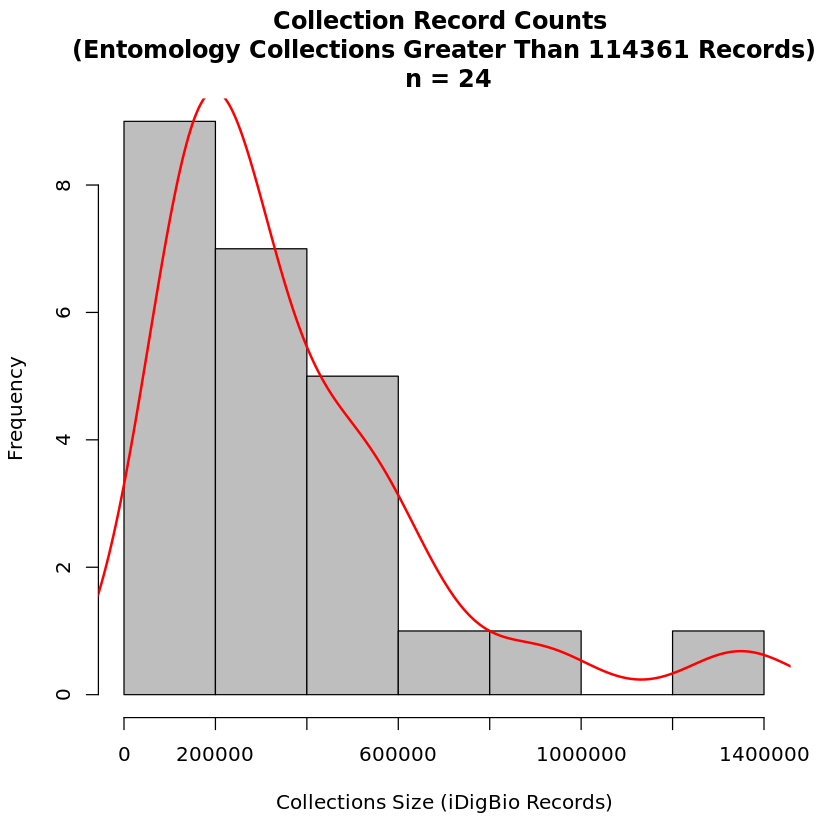

In [33]:
entoL <- df %>% filter(grepl("arthropoda",type,ignore.case = T))%>% arrange(desc(count)) %>% filter(count>=quantile(ento$count)[4]) 

# Make histogram
options(scipen=999)
histBreaks <- hist(entoL$count, main = paste0("Collection Record Counts \n (Entomology Collections Greater Than ",quantile(ento$count)[4]," Records) \n n = ",nrow(entoL)),xlab = "Collections Size (iDigBio Records)",col = "grey")
#axis(1, at=seq(0,1400000,by=200000),labels = c("0","200,000","400,000","600,000","800,000","1m","1.2m","1.4m")) 
d <- density(entoL$count)
lines(x = d$x, y = d$y * length(entoL$count) * diff(hist(entoL$count,plot = F)$breaks)[1], lwd = 2,col="red")

In [ ]:
## Subset to herb collections
herb <- df %>% filter(grepl("plantae",type,ignore.case = T)) %>% arrange(desc(count))

# Make histogram
options(scipen=999)
histBreaks <- hist(herb$count, main = paste0("Collection Record Counts \n (Herbarium) \n n = ",nrow(herb)),xlab = "Collections Size (iDigBio Records)",col = "grey",xaxt="no")
axis(1, at=seq(0,4000000,by=500000),labels = c("0","500,000","1m","1.5m","2m","2.5m","3m","3.5m","4m")) 
d <- density(herb$count)
lines(x = d$x, y = d$y * length(herb$count) * diff(hist(herb$count,plot = F)$breaks)[1], lwd = 2,col="red")